# Comparing allelic imbalance test results between EpiSCs in bulk RNA-seq and pseudo-bulk scRNA

### Figure 6A

In [1]:
# Loading libraries
suppressPackageStartupMessages({
  library(ggplot2)
  library(ggsci)
  library(ggthemes)
  library(ggpointdensity)
  library(ggpubr)
  library(gridExtra)
  library(tibble)
  library(openxlsx)
  library(dplyr)
  library(reshape2)
})

In [29]:
#Functions
#if multiple conditions are stored in the columns,
#the function return the instance where the condition is met first
#i.e. the column order in which condition is set to TRUE
find_first_true <- function(row) {
  true_position <- which(row == TRUE)
  if (length(true_position) > 0) {
    return(true_position[1])
  } else {
    return(0)
  }
}


#scatter plot of allelic ratios betwen pseudo-bulk and bulk data
comp_AI <- function(plot_data){
    ggplot(plot_data, aes(x = AI_scRNA, y = AI_bulk, color = gene_group)) +
    #ggplot(plot_data, aes(x = pseudobulk_scRNA.bb_mu, y = bulk.bb_mu, color = gene_group)) +
     geom_abline(slope=1, intercept=0, colour = "darkgrey", linetype = "dashed", linewidth = 0.35) +
     geom_point(size = 0.7, alpha = 0.7) +
     theme_classic(base_size = 20) +
     theme(panel.border = element_rect(colour = "black", fill=NA, size=1)) +
     labs(x = "Allelic ratio (scRNA)", y = "Allelic ratio (bulk RNA)") +
     scale_color_manual(values = ggthemes_data$excel$themes$Badge$accents[c(2,4,3,1)],
                      labels = c("not significant", "significant in scRNA",
                                 "significant in bulk RNA", "significant in both")) +
     theme(legend.position = "bottom", legend.text = element_text(size = 12),
          legend.title = element_blank()) +
     geom_point(data = subset(plot_data, gene_group == "3"), aes(x = AI_scRNA, y = AI_bulk), 
                color = ggthemes_data$excel$themes$Badge$accents[1], size  = 0.7) +
     guides(color = guide_legend(override.aes = list(size = 4), nrow = 2)) +
     annotate("text", x=0.6, y=0.01, label= paste("Pearson Correlation : ", round(cor(plot_data$AI_scRNA, plot_data$AI_bulk), 2)), size = 5) +
     annotate("text", x=0.75, y=0.07, label= paste("N genes:", nrow(plot_data)), size = 5) +
     annotate("text", x=0.75, y=0.13, label= paste("Overlap:", table(plot_data$gene_group)[4]), size = 5) 
} 


Loading test results for bulk RNA-seq and pseudo-bulk scRNA

In [5]:
strains <- c("Cast", "Molf", "Pwk", "Spret")
res_dir <- "data/bbtest_res/"
episc_sc_test <- list()
for (i in 1:length(strains)){
  episc_sc_test[[i]] <- read.xlsx(paste0(res_dir, "EpiSCs_scRNA_exons.xlsx"), sheet = i, rowNames = T)
}

#Bulk test object contains results for both EpiSCs and iPSCs, selecting odd numbers only that correspond to EpiSCs
bulk_test <- list()
for (i in c(1,3,5,7)){
    bulk_test[[i]] <- read.xlsx(paste0(res_dir, "bulkRNA_exons.xlsx"), sheet = i, rowNames = T)
}

Find the common sets of genes that are present in both pseudobulk and bulk datasets

In [17]:
set.seed(101011001)
bulk_test <- bulk_test[lengths(bulk_test) > 0]
plot_data <- list()
for (i in c(1:4)){
    plot_data[[i]] <- data.frame(AI_scRNA = episc_sc_test[[i]]$AI.1,
                        fdr_scRNA = episc_sc_test[[i]]$fdr_shrunk,
                        log2FC_scRNA =  episc_sc_test[[i]]$log2FC)
    rownames(plot_data[[i]]) <- rownames(episc_sc_test[[i]])
    plot_data[[i]]$AI_bulk <- bulk_test[[i]]$AI.1[match(rownames(plot_data[[i]]), rownames(bulk_test[[i]]))]
    plot_data[[i]]$fdr_bulk <- bulk_test[[i]]$fdr_shrunk[match(rownames(plot_data[[i]]), rownames(bulk_test[[i]]))]
    plot_data[[i]]$log2FC_bulk <- bulk_test[[i]]$log2FC[match(rownames(plot_data[[i]]), rownames(bulk_test[[i]]))]
    plot_data[[i]] <- na.omit(plot_data[[i]])
    plot_data[[i]]$signif_scRNA <- ifelse(plot_data[[i]]$fdr_scRNA < 0.05, 1, 0)
    plot_data[[i]]$signif_bulk <- ifelse(plot_data[[i]]$fdr_bulk < 0.05, 1, 0)
    #significant in bulk only
    plot_data[[i]]$C1 <- plot_data[[i]]$signif_scRNA == 0 & plot_data[[i]]$signif_bulk == 1
    #significant in scRNA only
    plot_data[[i]]$C2 <- plot_data[[i]]$signif_scRNA == 1 & plot_data[[i]]$signif_bulk == 0
    #significant in both
    plot_data[[i]]$C3 <- plot_data[[i]]$signif_scRNA == 1 & plot_data[[i]]$signif_bulk == 1
    #assigning gene to the relevant group
    plot_data[[i]]$gene_group <- apply(plot_data[[i]][,c(9:11)], 1, find_first_true)
    plot_data[[i]]$gene_group <- factor(plot_data[[i]]$gene_group, levels = c("0", "2", "1", "3"))
}

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

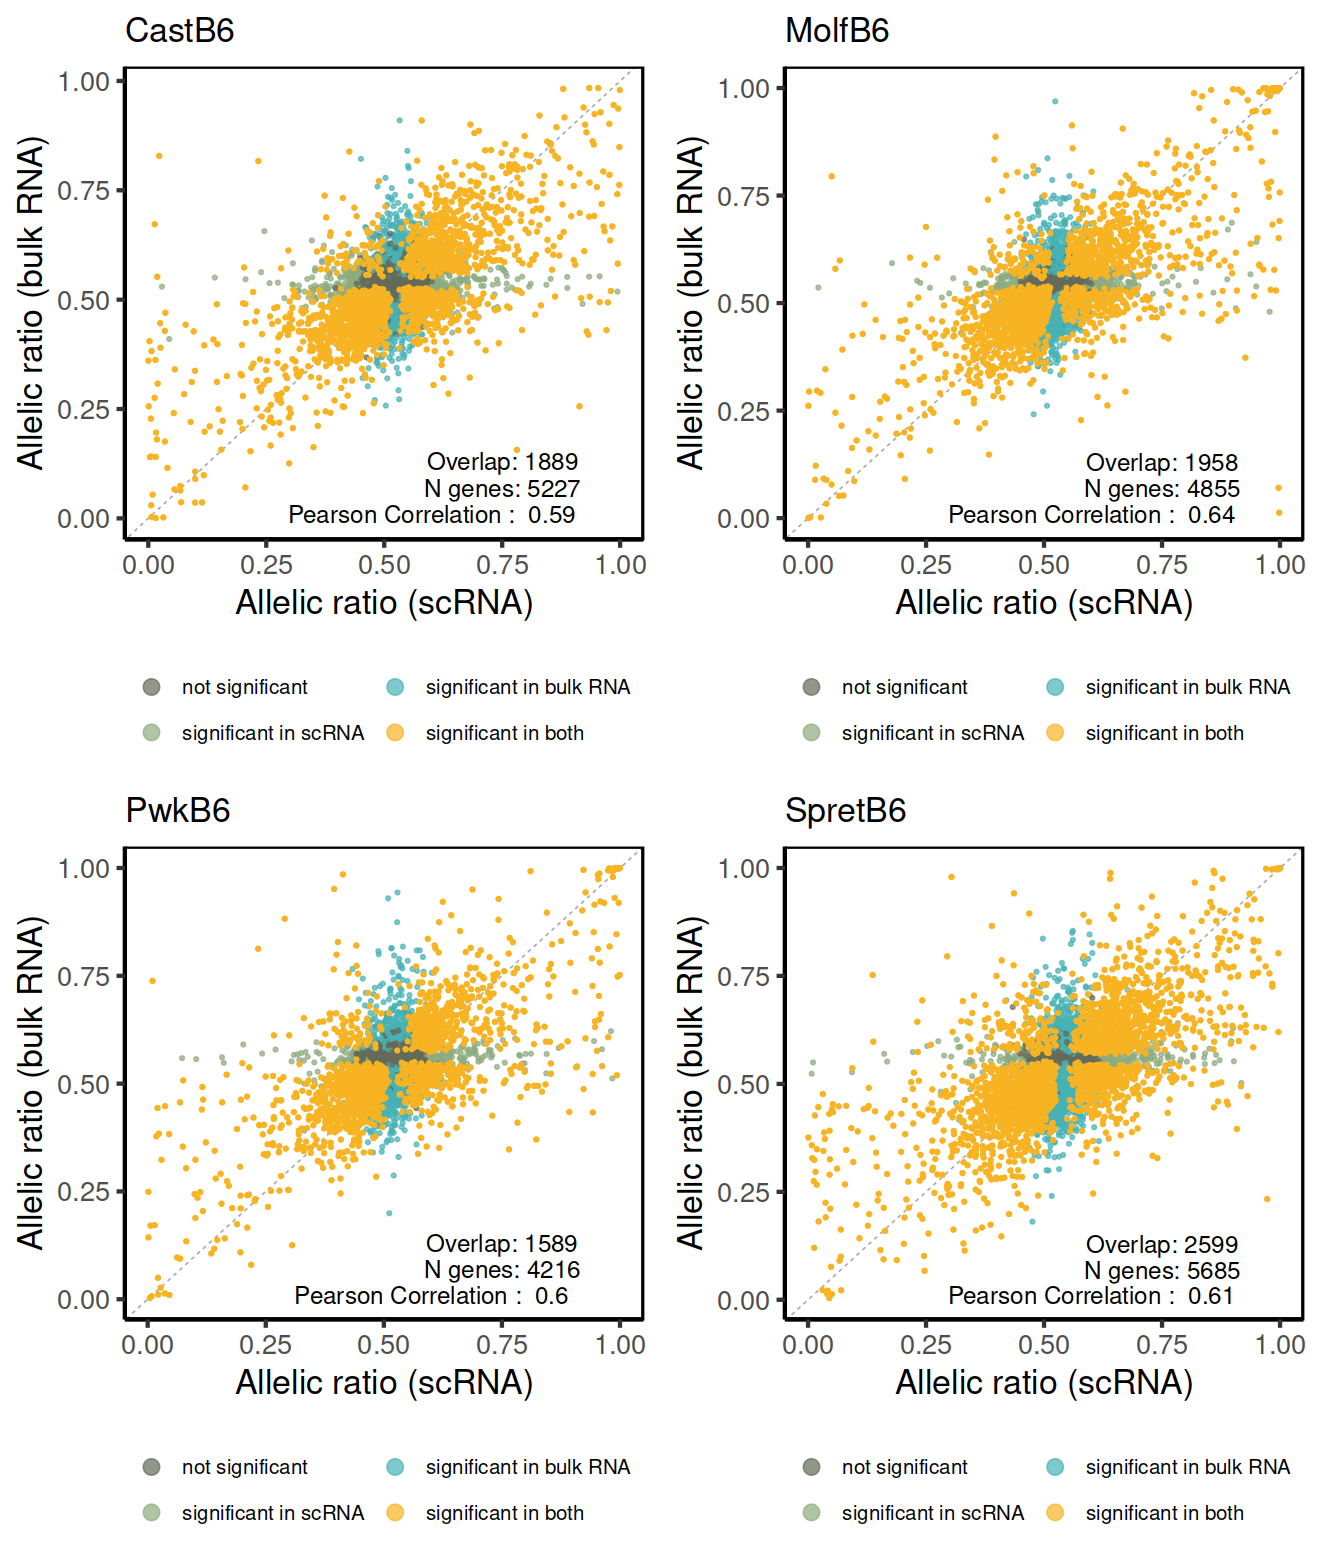

In [30]:
options(repr.plot.width = 11, repr.plot.height = 13)
p <- mapply(function(p,q) comp_AI(p) + labs(subtitle = paste0(q, "B6")), plot_data, strains, SIMPLIFY =F)
comb <- do.call("grid.arrange", c(p, ncol = 2))
comb            